### Import required packages:

In [3]:
import numpy as np
import astropy.io.fits
import random
import os
import os.path
from collections import Counter
from PIL import Image
from sklearn.cluster import KMeans
from astropy.time import Time
import csv
from statistics import stdev
from statistics import mean
import math
from matplotlib import pyplot as plt
import pandas as pd
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm
import cudf
from cuml.cluster import DBSCAN
from cuml.cluster import KMeans as cudkmean
import timeit

### Functions:


In [4]:

# Normalizing between [1,-1]
def normal(a):
    
    aa = a - a.min()
    bb = a.max() - a.min()
    cc = (2 * aa) / bb
    dd = cc - 1
    return dd


# Unnormal

def unnormal(norm, pure):
    ee = norm + 1
    ff = ee/2
    gg = ff * (pure.max() - pure.min())
    hh = gg + pure.min()
    return hh


# Getting Features

def getFeatures(Name):
    fileData = astropy.io.fits.open(Name)
    B = fileData[1].data
    B = np.array(B, dtype=np.float32)
    Binc = fileData[2].data
    Binc = np.array(Binc, dtype=np.float32)
    Bazi = fileData[3].data
    Bazi = np.array(Bazi, dtype=np.float32)
    DopF = fileData[4].data
    DopF = np.array(DopF, dtype=np.float32)
    #DopS = fileData[5].data
    #DopS = np.array(DopS, dtype=np.float64)
    SLFF = fileData[12].data
    SLFF = np.array(SLFF, dtype=np.float32)
    CI = fileData[32].data
    CI = np.array(CI, dtype=np.float32)


    return B, Binc, Bazi, DopF, SLFF, CI


# Removing that effect due to doppler shifts

def canNoise(Doppler):
    
    y = np.mean(Doppler, 0)
    x = np.array(range(Doppler.shape[1]))
    m, b = np.polyfit(x, y, 1)
    v = m*x + b
    out = Doppler - v

    return out

# Normalizing angles

def normangle(feature):
    
    
    a = np.cos(np.deg2rad(feature))
    
    return a
      

# Making a list for dimensions of observations
def dimlist(filenames):
    
    dimList = list()


    for i in NewList:

        file = astropy.io.fits.open(i)
        x, y = file[1].data.shape
        dimList.append((x, y))
    
    return dimList


# Concatenating all the observations

def concatfeatures(NewList):

    Btot, Binctot, DopFtot, SLFFtot, CItot = np.array([]), np.array([]),np.array([]), np.array([]),np.array([])



    for j in NewList:

        B, Binc, Bazi, DopF, SLFF, CI = getFeatures(j)
        Btot = np.concatenate((Btot, B), axis=None)
        Binctot = np.concatenate((Binctot, Binc), axis=None)
        DopFtot = np.concatenate((DopFtot, canNoise(DopF)), axis=None)
        SLFFtot = np.concatenate((SLFFtot, SLFF), axis=None)
        CItot = np.concatenate((CItot, CI), axis=None)
    
    
    return Btot, Binctot, DopFtot, SLFFtot, CItot

#Concateraw
def conpure(NewList):

    Btot, DopFtot, SLFFtot, CItot = np.array([]),np.array([]), np.array([]),np.array([])

    for j in NewList:

        B, Binc, Bazi, DopF, SLFF, CI = getFeatures(j)
        Btot = np.concatenate((Btot, B), axis=None)
        DopFtot = np.concatenate((DopFtot, DopF), axis=None)
        SLFFtot = np.concatenate((SLFFtot, SLFF), axis=None)
        CItot = np.concatenate((CItot, CI), axis=None)
    
    
    return Btot, DopFtot, SLFFtot, CItot


# Plot mappings
def pltmaps(labels, dimList, k):
    
    start = 0
    end = 0

    for s, tple in enumerate(dimList):

        end += tple[0] * tple[1]

        pltimg(labels[start:end], tple, s)

        start = end 
        
def pltimg(labels, tple, s):
    
    fileData = (NewList[s])
    v = fileData[42:-5]
    labless = labels.reshape(tple)
    plt.figure(figsize=(16,9))
    plt.imshow(labless, cmap="viridis", origin="bottom")
    plt.colorbar()
    plt.savefig(dir+'/'+ v + '.png')

#getting a window of 150*150 in each map to make our data-set
def confe(NewList):

    Btot, Binctot, DopFtot, SLFFtot, CItot = np.array([]), np.array([]),np.array([]), np.array([]),np.array([])



    for j in NewList:

        B, Binc, Bazi, DopF, SLFF, CI = getFeatures(j)
        x, y = B.shape
        yy = random.randint(0, y-151)
        xx = random.randint(0, x-151)
        
        BB = B[xx:xx+150, yy:yy+150]
        
        BBinc = Binc[xx:xx+150, yy:yy+150]
        
        DopFF = canNoise(DopF)
        DDopF = DopFF[xx:xx+150, yy:yy+150]
        
        FF = SLFF[xx:xx+150, yy:yy+150]
        
        CCI = CI[xx:xx+150, yy:yy+150]

        Btot = np.concatenate((Btot, BB), axis=None)
        Binctot = np.concatenate((Binctot, BBinc), axis=None)
        DopFtot = np.concatenate((DopFtot, DDopF), axis=None)
        SLFFtot = np.concatenate((SLFFtot, FF), axis=None)
        CItot = np.concatenate((CItot, CCI), axis=None)
    
    
    return Btot, Binctot, DopFtot, SLFFtot, CItot


In [ ]:
# Reading our files in related directory
NorthDir='/glade/work/egeland/hinode_synoptic/north'
allfiles = [os.path.join(NorthDir, f) for f in sorted(os.listdir(NorthDir))]

# Removing all sav files
NewList=[item for i,item in enumerate(allfiles) if i%2==0]
b = []

#Getting only fastmaps
for item in NewList:
    
    fileData = astropy.io.fits.open(item)
    a = fileData[0].header['YSCALE']
    if a > 0.16 :
        b.append(item)
        
NewList = b

# concatenating all samples(pixels) in each feature
Btot, Binctot, DopFtot, SLFFtot, CItot = concatfeatures(NewList)

for it, item in enumerate(Btot):
    
    if item < 200:
        
        Btot[it] = 0
        Binctot[it] = 90
        SLFFtot[it] = 0
        
    elif item > 2000:
        
        Btot[it] = 2000
        
        

# Normalizing Features
Btotn = normal(Btot)
Binctotn = normangle(Binctot)
DopFtotn = normal(DopFtot)
SLFFtotn = normal(SLFFtot)
CItotn = normal(CItot)

# Preparing the input for our clustering method
da = np.array([Btotn, Binctotn, DopFtotn, SLFFtotn, CItotn])
fda = np.transpose(da)

In [9]:
# transfer the data to cudf for using cuda
cudf.set_allocator("managed")
X_df = pd.DataFrame({'fea%d'%i: fda[:, i] for i in range(fda.shape[1])})
X_gpu = cudf.DataFrame.from_pandas(X_df)

print(X_gpu)

          fea0          fea1      fea2  fea3      fea4
0         -1.0  6.123234e-17 -0.115495  -1.0 -0.450234
1         -1.0  6.123234e-17 -0.094160  -1.0 -0.403435
2         -1.0  6.123234e-17 -0.153336  -1.0 -0.300402
3         -1.0  6.123234e-17 -0.158472  -1.0 -0.338802
4         -1.0  6.123234e-17 -0.117647  -1.0 -0.446365
...        ...           ...       ...   ...       ...
22620155  -1.0  6.123234e-17  0.005380  -1.0 -0.694710
22620156  -1.0  6.123234e-17 -0.024582  -1.0 -0.701551
22620157  -1.0  6.123234e-17 -0.075808  -1.0 -0.708145
22620158  -1.0  6.123234e-17 -0.107269  -1.0 -0.726295
22620159  -1.0  6.123234e-17 -0.068694  -1.0 -0.704469

[22620160 rows x 5 columns]


Time:  534.2234394800034


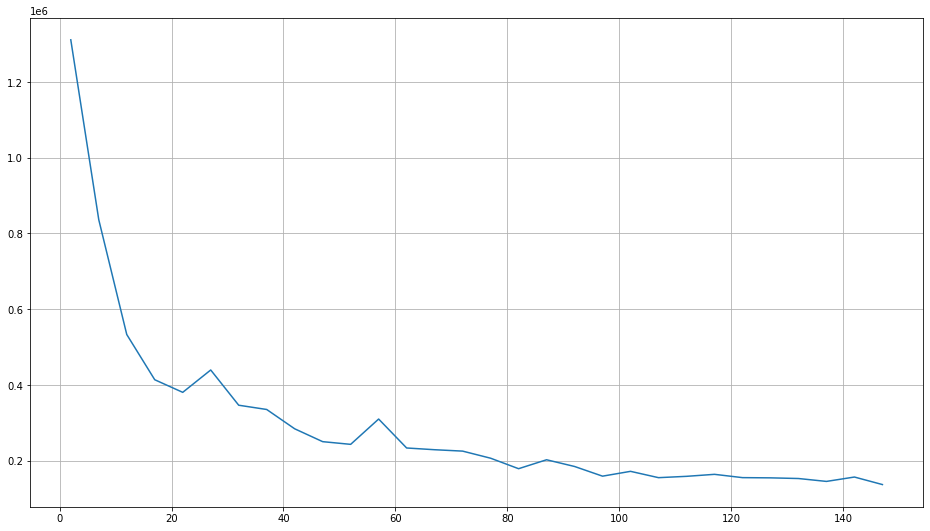

In [11]:
# Calculating number of clusters based on Inertia for Kmeans
kk = np.array(range(2,151,5))
inlist = np.array([])

start = timeit.default_timer()
for k in kk:

    cud = cudkmean(n_clusters = k)
    cud.fit(X_gpu)
    inert = cud.score(X_gpu)
    inlist = np.append(inlist, inert)
    stop = timeit.default_timer()

print('Time: ', stop - start) 

plt.figure(figsize=(16,9))
plt.plot(kk, np.abs(inlist))
plt.grid(True)
plt.show()